In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, Iterator,
                                       array_to_img, img_to_array, load_img)
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import sys, os
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow_model_optimization as tfmot
import shap
import keras
import matplotlib.cm as cm
from IPython.display import Image

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
# sess.as_default()

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# for physical_device in physical_devices:
#     tf.config.experimental.set_memory_growth(physical_device, True)

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
tf.__version__

'2.3.0'

In [4]:
%matplotlib inline

In [5]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### Data Generator

In [6]:
train_data_dir = '../data/CollisionData/'

img_width, img_height = 96, 96 # 224, 224
nb_train_samples = 730 
nb_validation_samples = 181
epochs = 25
batch_size = 16

if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    ) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation') # set as validation data

Found 730 images belonging to 2 classes.
Found 181 images belonging to 2 classes.


## Model Architectures

### EuroSat

Original model

In [8]:
# original model
# finetune_model = tf.keras.Sequential([
#     layers.InputLayer(input_shape=input_shape),
#     layers.BatchNormalization(),
#     layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='elu'),
#     layers.MaxPool2D(),
    
#     layers.BatchNormalization(),
#     layers.Conv2D(32, 3, padding='same', activation='elu'),
#     layers.Conv2D(32, 3, padding='same', activation='elu'),
#     layers.MaxPool2D(),
    
#     layers.BatchNormalization(),
#     layers.Conv2D(64, 3, padding='same', activation='elu'),
#     layers.Conv2D(64, 3, padding='same', activation='elu'),
#     layers.MaxPool2D(),
    
#     layers.Flatten(),
#     layers.Dense(128, activation='elu'),
#     layers.Dropout(0.5),
#     layers.Dense(64, activation='elu'),
#     layers.Dropout(0.5),
#     layers.Dense(1, activation='sigmoid')
# ])

# finetune_model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy', 
#     metrics=['accuracy']
# )

Tiny Compatible

In [8]:
finetune_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

finetune_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr = 1e-5, decay = 1e-5),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

### MobileNet V1

All layer trainable, imagenet initialized

In [11]:
# def build_finetune_model(base_model, dropout, fc_layers, num_classes):
#     for layer in base_model.layers:
#         layer.trainable = True #change this to False is retraining is not to be done in base layers

#     x = base_model.output
#     x = Flatten()(x)
#     for fc in fc_layers:
#         # New FC layer, random init
#         x = Dense(fc, activation='relu')(x) 
#         x = Dropout(dropout)(x)

#     # New softmax layer
#     predictions = Dense(1, activation='sigmoid')(x) 
    
#     finetune_model = Model(inputs=base_model.input, outputs=predictions)

#     return finetune_model

# base_model = MobileNet(weights='imagenet', 
#                       include_top=False, 
#                       input_shape=input_shape)

# class_list = ['CollisionOrClose', 'NoCollision']
# FC_LAYERS = [256, 256]
# dropout = 0.5

# finetune_model = build_finetune_model(base_model, 
#                                       dropout=dropout, 
#                                       fc_layers=FC_LAYERS, 
#                                       num_classes=len(class_list))

### Simple CNN

In [ ]:
# finetune_model = Sequential() 
# finetune_model.add(Conv2D(32, (2, 2), input_shape = input_shape)) 
# finetune_model.add(Activation('relu')) 
# finetune_model.add(MaxPooling2D(pool_size =(2, 2))) 
  
# finetune_model.add(Conv2D(32, (2, 2))) 
# finetune_model.add(Activation('relu')) 
# finetune_model.add(MaxPooling2D(pool_size =(2, 2))) 
  
# finetune_model.add(Conv2D(64, (2, 2))) 
# finetune_model.add(Activation('relu')) 
# finetune_model.add(MaxPooling2D(pool_size =(2, 2))) 
  
# finetune_model.add(Flatten()) 
# finetune_model.add(Dense(64)) 
# finetune_model.add(Activation('relu')) 
# finetune_model.add(Dropout(0.5)) 
# finetune_model.add(Dense(1)) 
# finetune_model.add(Activation('sigmoid')) 

## Training and Testing

In [9]:
callbacks = [
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 5,
                 min_delta=0.001, restore_best_weights=True
             )
]

history = finetune_model.fit(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size, shuffle=True, callbacks = callbacks) 

Epoch 1/25
45/45 [==============================] - 10s 224ms/step - loss: 0.6604 - accuracy: 0.6289 - val_accuracy: 0.7670 - val_loss: 0.6718
Epoch 2/25
45/45 [==============================] - 10s 223ms/step - loss: 0.5664 - accuracy: 0.7339 - val_accuracy: 0.7670 - val_loss: 0.6529
Epoch 3/25
45/45 [==============================] - 10s 223ms/step - loss: 0.5337 - accuracy: 0.7493 - val_accuracy: 0.7670 - val_loss: 0.6432
Epoch 4/25
45/45 [==============================] - 10s 221ms/step - loss: 0.5154 - accuracy: 0.7591 - val_accuracy: 0.7670 - val_loss: 0.6302
Epoch 5/25
45/45 [==============================] - 10s 224ms/step - loss: 0.5009 - accuracy: 0.7619 - val_accuracy: 0.7670 - val_loss: 0.6115
Epoch 6/25
45/45 [==============================] - 10s 218ms/step - loss: 0.4854 - accuracy: 0.7507 - val_accuracy: 0.7670 - val_loss: 0.5988
Epoch 7/25
45/45 [==============================] - 10s 224ms/step - loss: 0.4666 - accuracy: 0.7745 - val_accuracy: 0.7670 - val_loss: 0.5736

### Model Summary

In [10]:
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 96, 96, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0

### Model Size

In [11]:
finetune_model.save("./my-log-dir/eurosat_model.h5")

In [12]:
import os
b = os.path.getsize("./my-log-dir/eurosat_model.h5")

print ("Model Size(mb): %d" % (b/1000000))

Model Size(mb): 15


### Performance

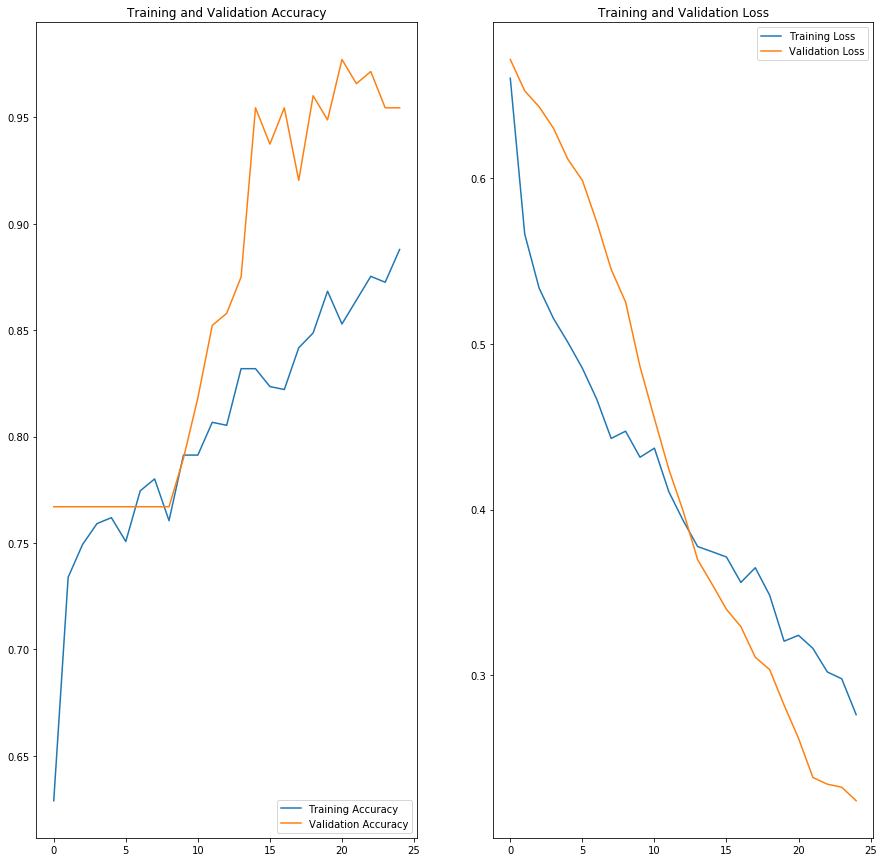

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix
from keras.utils import Sequence


probabilities = finetune_model.predict_generator(generator=validation_generator)
# print(probabilities)

Instructions for updating:
Please use Model.predict, which supports generators.


In [15]:
y_true = validation_generator.classes
y_pred = probabilities > 0.5
class_labels = list(validation_generator.class_indices.keys())  

In [16]:
report = metrics.classification_report(y_true, y_pred, target_names=class_labels)
print(report)  

                  precision    recall  f1-score   support

CollisionOrClose       0.97      0.88      0.92        41
     NoCollision       0.97      0.99      0.98       140

        accuracy                           0.97       181
       macro avg       0.97      0.94      0.95       181
    weighted avg       0.97      0.97      0.97       181



In [17]:
mat = confusion_matrix(y_true, y_pred)
print(mat)

[[ 36   5]
 [  1 139]]


### Analyze Results

In [18]:
def plotImages1(images_arr, y1, y2, row_size):
    fig, axes = plt.subplots(1, row_size, figsize=(20,20))
    axes = axes.flatten()
    for img, l, p, ax in zip(images_arr, y1, y2, axes):
        ax.imshow(img)
        ax.set_title("Label:"+str(int(l))+", Pred:"+str(int(p)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

<Figure size 1440x1440 with 0 Axes>

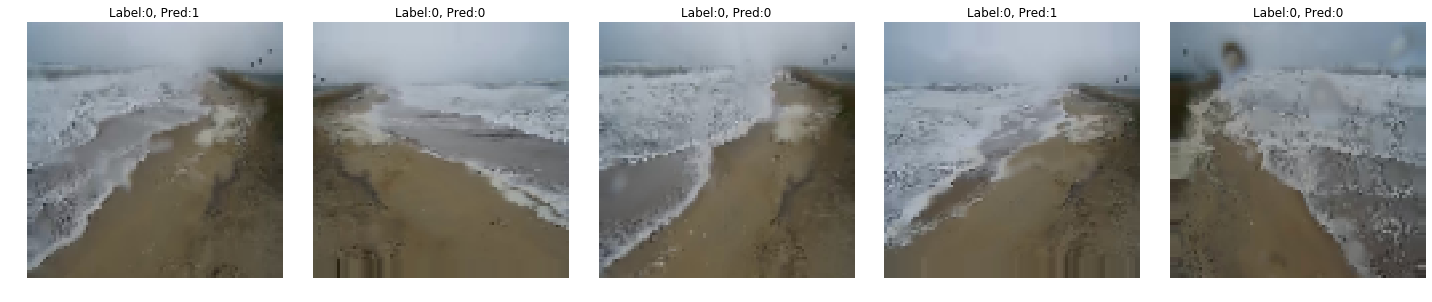

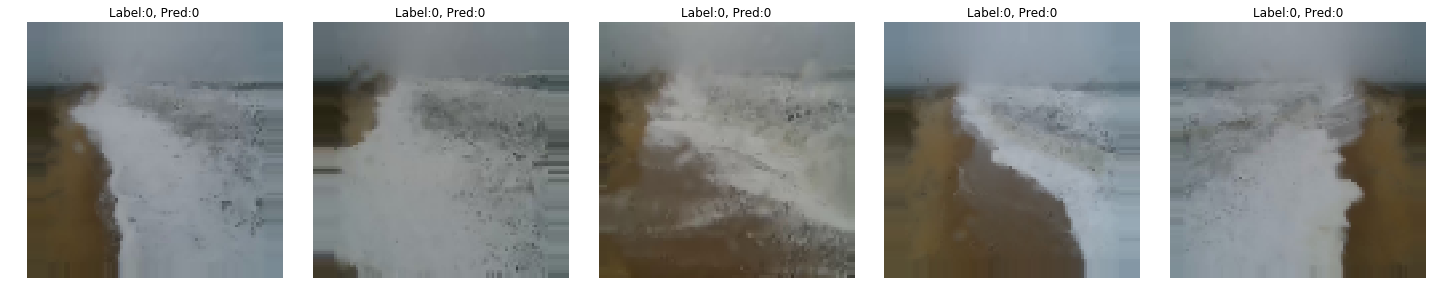

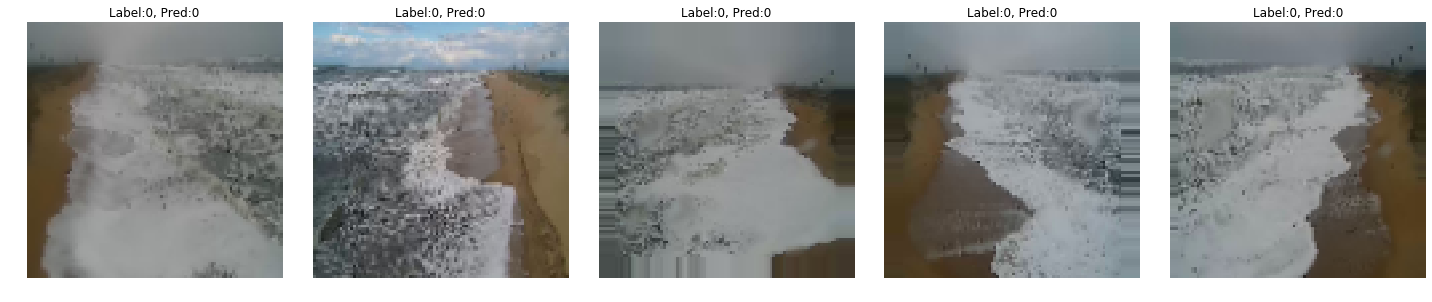

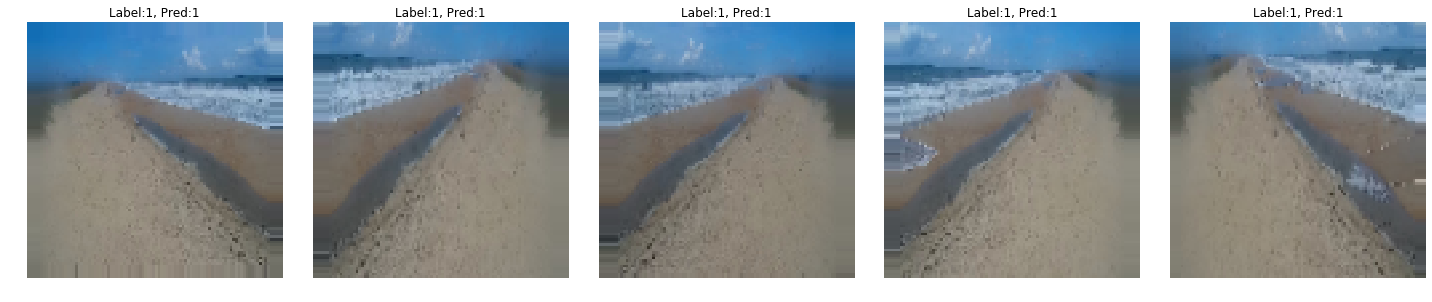

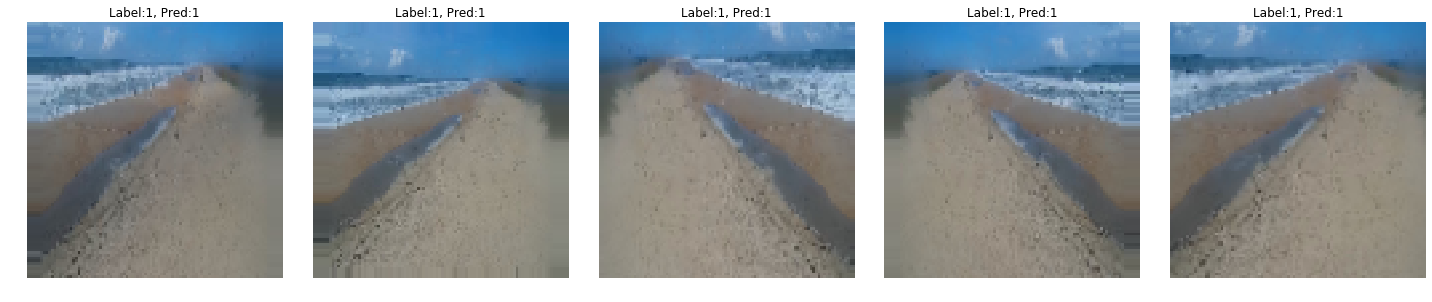

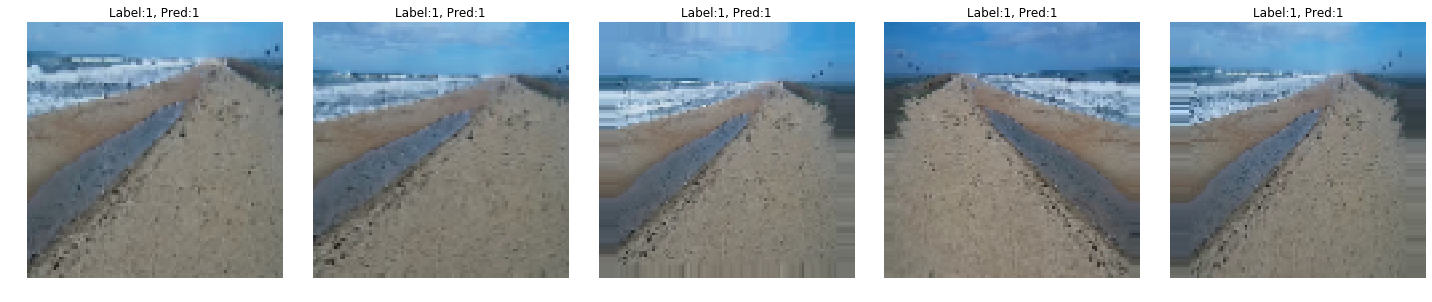

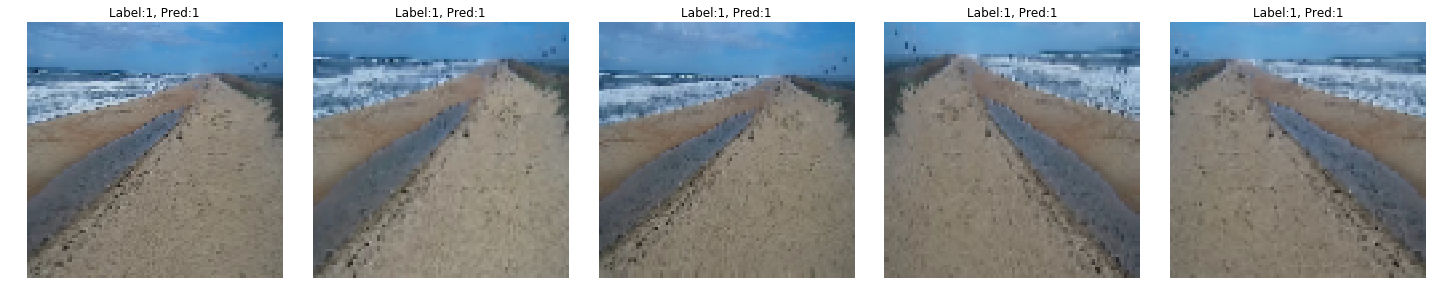

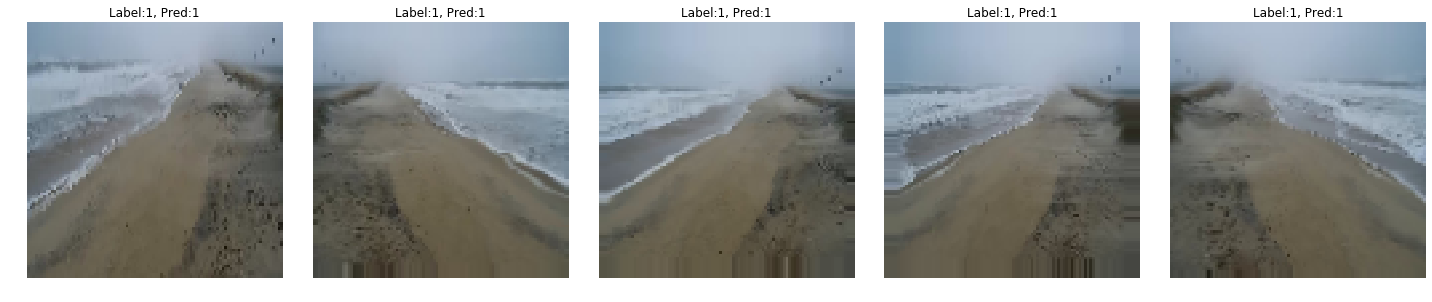

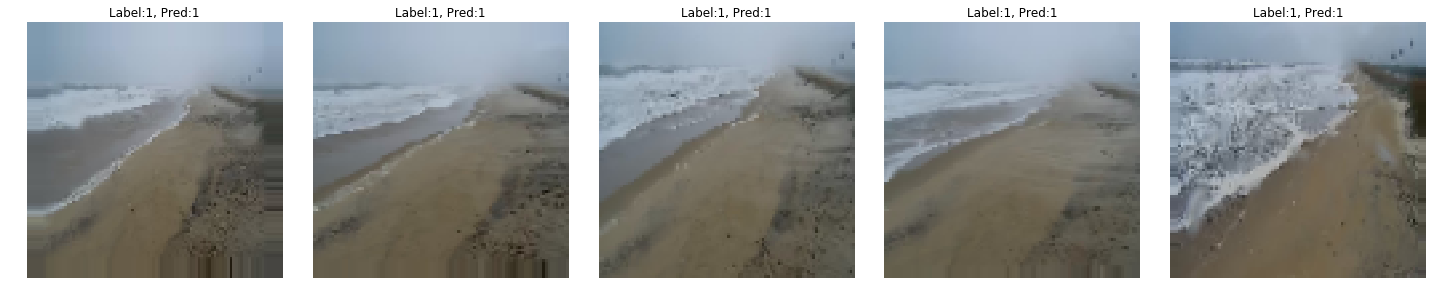

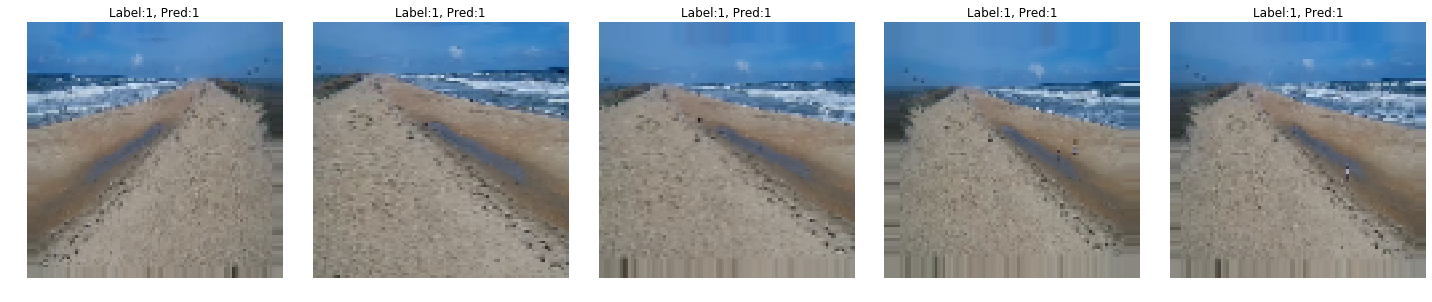

In [19]:
cnt = 0
row_size = 5
validation_generator.reset()
fig=plt.figure(figsize=(20,20))

ax = []
for i in range(10):
    x,y = next(validation_generator)
    img = x[:row_size]
    y_label = y[:row_size]
    y_predicted = y_pred[cnt:cnt+row_size]
    plotImages1(img, y_label, y_predicted, row_size)
    cnt += 16

In [20]:
labels = (validation_generator.class_indices)

In [21]:
labels

{'CollisionOrClose': 0, 'NoCollision': 1}

## Optimization

### Pruning

In [22]:
end_step = np.ceil(1.0 * nb_train_samples / batch_size).astype(np.int32) * epochs

pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(finetune_model, pruning_schedule=pruning_schedule)
model_for_pruning.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 96, 96, 3)         13        
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 96, 96, 16)        2418      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 48, 48, 16)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 48, 48, 16)        65        
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 48, 48, 32)        9250      
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 48, 48, 32)        18466     
_________________________________________________

In [23]:
logdir = './my-log-dir/'

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
  
model_for_pruning.fit(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size, shuffle=True, callbacks = callbacks)

Epoch 1/25
 1/45 [..............................] - ETA: 0s - loss: 0.6123 - accuracy: 0.6250WARNING:tensorflow:From /home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
45/45 [==============================] - 11s 234ms/step - loss: 0.4590 - accuracy: 0.7507 - val_accuracy: 0.8068 - val_loss: 0.2724
Epoch 2/25
45/45 [==============================] - 10s 225ms/step - loss: 0.3332 - accuracy: 0.8291 - val_accuracy: 0.9886 - val_loss: 0.0914
Epoch 3/25
45/45 [==============================] - 10s 224ms/step - loss: 0.3122 - accuracy: 0.8754 - val_accuracy: 0.9261 - val_loss: 0.1653
Epoch 4/25
45/45 [==============================] - 10s 226ms/step - loss: 0.2402 - accuracy: 0.8936 - val_accuracy: 0.9886 - val_loss: 0.1033
Epoch 5/25
45/45 [=====================

In [25]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(validation_generator, verbose=0)

print('Pruned test accuracy:', model_for_pruning_accuracy)


Pruned test accuracy: 0.950276255607605


#### Export Pruned Model

In [26]:
from tensorflow_model_optimization.sparsity import keras as sparsity

final_model = sparsity.strip_pruning(model_for_pruning)
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 96, 96, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0

In [27]:
from tensorflow.keras.models import load_model
import numpy as np

# model = tf.keras.models.load_model(final_model)


for i, w in enumerate(final_model.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            final_model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )

batch_normalization/gamma:0 -- Total:3, Zeros: 0.00%
batch_normalization/beta:0 -- Total:3, Zeros: 0.00%
batch_normalization/moving_mean:0 -- Total:3, Zeros: 0.00%
batch_normalization/moving_variance:0 -- Total:3, Zeros: 0.00%
conv2d/kernel:0 -- Total:1200, Zeros: 90.00%
conv2d/bias:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/gamma:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/beta:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/moving_mean:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/moving_variance:0 -- Total:16, Zeros: 0.00%
conv2d_1/kernel:0 -- Total:4608, Zeros: 90.00%
conv2d_1/bias:0 -- Total:32, Zeros: 0.00%
conv2d_2/kernel:0 -- Total:9216, Zeros: 90.00%
conv2d_2/bias:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/gamma:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/beta:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/moving_mean:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/moving_variance:0 -- Total:32, Zeros: 0.00%
conv2d_3/kernel:0 -- Total:18432

In [28]:
import tempfile
import zipfile

# _, new_pruned_keras_file = tempfile.mkstemp(".h5")

new_pruned_keras_file = "./my-log-dir/saved_model/pruned_model.h5"
print("Saving pruned model to: ", new_pruned_keras_file)
tf.keras.models.save_model(final_model, new_pruned_keras_file, include_optimizer=False)


final_model.save('./my-log-dir/saved_model/')

# Zip the .h5 model file
_, zip3 = tempfile.mkstemp(".zip")
with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
    f.write(new_pruned_keras_file)
print(
    "Size of the pruned model before compression: %.2f Mb"
    % (os.path.getsize(new_pruned_keras_file) / float(2 ** 20))
)
print(
    "Size of the pruned model after zip compression: %.2f Mb"
    % (os.path.getsize(zip3) / float(2 ** 20))
)

Saving pruned model to:  ./my-log-dir/saved_model/pruned_model.h5
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./my-log-dir/saved_model/assets
Size of the pruned model before compression: 4.85 Mb
Size of the pruned model after zip compression: 0.89 Mb


#### Quantize

In [29]:
keras_model = tf.keras.models.load_model(new_pruned_keras_file)

tflite_model_file = "./my-log-dir/saved_model/quantized.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model('./my-log-dir/saved_model/')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [30]:
print(
    "Size of the pruned model before compression: %.2f Mb"
    % (os.path.getsize("./my-log-dir/saved_model/quantized.tflite") / float(2 ** 20))
)

Size of the pruned model before compression: 1.21 Mb


In [31]:
# Zip the .h5 model file
_, zip3 = tempfile.mkstemp(".zip")
with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
    f.write(tflite_model_file)
print(
    "Size of the pruned and quantized model before compression: %.2f Mb"
    % (os.path.getsize(tflite_model_file) / float(2 ** 20))
)
print(
    "Size of the pruned and quantized model after zip compression: %.2f Mb"
    % (os.path.getsize(zip3) / float(2 ** 20))
)

Size of the pruned and quantized model before compression: 1.21 Mb
Size of the pruned and quantized model after zip compression: 0.19 Mb


#### Evaluate the quantized model

In [61]:
x=[]
y=[]
validation_generator.reset()
x=np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
y=np.concatenate([validation_generator.next()[1] for i in range(validation_generator.__len__())])
print(x.shape)
print(y.shape)

(181, 96, 96, 3)
(181,)


In [63]:
interpreter = tf.lite.Interpreter(model_path=str("./my-log-dir/saved_model/quantized.tflite"))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]


def eval_model(interpreter, x_test, y_test):
    total_seen = 0
    num_correct = 0

    for img, label in zip(x_test, y_test):
        inp = np.expand_dims(img, axis=0).astype(np.float32)
        total_seen += 1
        interpreter.set_tensor(input_index, inp)
        interpreter.invoke()
        
        predictions = interpreter.get_tensor(output_index)
        if predictions[0][0] > 0.5:
            predicted = 1
        else:
            predicted = 0
        if predicted == label:
            num_correct += 1
            
        if total_seen % 1000 == 0:
            print("Accuracy after %i images: %f" %
                  (total_seen, float(num_correct) / float(total_seen)))

    return float(num_correct) / float(total_seen)

print(eval_model(interpreter, x, y))



0.9281767955801105
